### Experiment on long-context instruction tuning dataset auto-generation based on CNKI papers in Chinese

#### step0. prepare the environment and the dependencies

In [1]:
import sys
sys.path.append("..")
import os
import json
import re

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv()) # openai_api_key

#### step1. load the raw pdf papers into chunked documents

In [2]:
from src.loader import load_pdf

In [57]:
language = "zh"

In [3]:
data_dir = "../data/raw/cnki_papers_zh_mini/"
chunk_size = 1000
chunk_overlap = 0

In [4]:
docs = load_pdf(dir_path=data_dir, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
docs


========================= Loading from 4 pdf files =========================



100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


========================= Loaded 114 documents =========================



[Document(page_content='No. 1, 2021 / Serial No.307\u3000\u3000随着移动通信技术的快速发展，移动智能终端的\n迅速普及，互联网商业模式的迭代创新，移动互联网\n已经深度嵌入到人们的学习、工作和生活场景。截至\n2019 年 12 月，我国网民规模达 9.04 亿，手机网民\n规模为 8.97 亿，我国国内市场上监测到的 App 数量\n为 367 万款[1]。如今人们越来越依赖智能手机等电子\n设备，并且将 App 作为生活中的必需品，通过 App\n进行通讯社交、购物支付、旅游住宿、资讯阅读、健身运动等。截至 2019 年 12 月，15~19 岁手机网民\n群体人均手机 App 数量最多，达 84 个；60 岁及以上\n手机网民群体人均手机 App 数量也有 37 个[1]。 App\n已成为收集、存储、处理和使用个人信息最为常见，也是最为重要的工具。App 在给用户生活带来便利的\n同时，也引起了用户对 App 信息安全、隐私风险等的\n担忧。中国消费者协会曾对 App 个人信息泄露情况开\n展问卷调查，调查结果显示：个人信息泄露情况相当严重，信息泄露途径和表现形式多样，消费者缺乏有\n效的保护手段\n[2]。中国消费者协会对 1 0类 共1 0 0款大数据时代读者个人信息保护的实践逻辑与规\n范路径*\n—— 以图书类 App 隐私政策文本为视角\n徐  磊\u3000郭  旭\n[ 摘\u3000要 ]\u3000 本文以 10 款排名靠前的图书类 App 隐私政策为研究对象，从个人信息的收集和使用、个人信息的存储和保护、读者\n个人信息权利等维度，对相关隐私政策文本进行分析。虽然运营商愈发重视隐私政策，但是隐私政策依然存在重点不明、规定模\n糊、利益偏向等问题。为了完善现有隐私政策和保护读者个人信息，应当提升读者在隐私政策制定和修订过程中的参与度；增强\n隐私政策的显著性和通俗性；夯实隐私政策法律基础，推动隐私政策迭代优化；提高隐私政策质量，注重未成年人信息保障；构建多元协同治理体系，确保隐私政策贯彻落实。\n[ 关键词 ]\u3000 个人信息保护\u3000图书\u3000隐私政策\u3000App\n[ 中图分类号 ]\u3000 G252 \u3000\u3000[ 文献分类号 ]\u

#### step2. build up a vector store and its corresponding retriever for the documents

In [6]:
from src.builder import build_retriever

In [7]:
retriever, vectorstore = build_retriever(
    documents=docs, 
    vs_type="chroma", 
    emb_type="openai", 
    retr_type="mmr"
)


========== Built a chroma retriever using the mmr searching strategy, based on the openai embeddings for 114 documents ==========



#### step3. build a qa generation chain to generate the seed QA pairs from the documents

In [41]:
from src.builder import build_qagen_chain

In [42]:
qagen_chain = build_qagen_chain(
    llm_name="gpt-3.5-turbo-1106", # 16k
    temperature=0.1,
)


The prompt template for QA generation chain is as belows:
You are a teacher coming up with questions to ask on a quiz. 
Given the following document, please generate a bunch of question and answer pairs based on that document in the language of {language}.

Example Format:
<Begin Document>
...
<End Document>
<QUESTIONS>:
questions here organized as a list of strings seperated by newlines
<ANSWERS>:
corresponding answers here organized as a list of strings seperated by newlines respectively

These questions should be detailed and be based explicitly on extractive information, synthetic knowledge, important relationship, casual reasoning, etc in the document. 
REMEMBER: all the generated questions and answers (excluding the title <QUESTIONS> and <ANSWERS>) should use the language of {language}, except those like terms or abbreviations that are not used in {language} in that document.
Begin!

<Begin Document>
{doc}
<End Document>

with input variables: ['doc', 'language'] | output parser

In [44]:
from src.applier import apply_qagen_chain

In [65]:
# NOTE: in the jupyter notebook, we can just use `await` to call the apply function,
# however, in a python script, we have to use asyncio.run(apply_qagen_chain(...)) to call it to avoid another running event loop as a RunTImeError
qa_pairs = await apply_qagen_chain( 
    chain=qagen_chain,
    documents=docs,
    language=language,
    async_apply=True # default to True to speed up
)


========================= Applying the QA generation chain to 114 documents =========================


========================= There are 777 QA pairs has been generated for 114 documents =========================



In [82]:
from src.utils import print_qa_pairs

In [73]:
print_qa_pairs(qa_pairs)


========================= For document 1 =========================

------------------------------
question1:  什么是中国网民规模？
answer1:  我国网民规模达 9.04 亿。
------------------------------
question2:  15~19岁手机网民群体人均手机 App 数量最多达到多少个？
answer2:  15~19岁手机网民群体人均手机 App 数量最多达 84 个。
------------------------------
question3:  60岁及以上手机网民群体人均手机 App 数量是多少？
answer3:  60岁及以上手机网民群体人均手机 App 数量为 37 个。
------------------------------
question4:  中国消费者协会对多少款大数据时代读者个人信息保护的实践逻辑与规范路径进行了调查？
answer4:  中国消费者协会对 100款大数据时代读者个人信息保护的实践逻辑与规范路径进行了调查。
------------------------------
question5:  本文以多少款排名靠前的图书类 App 隐私政策为研究对象？
answer5:  本文以 10款排名靠前的图书类 App 隐私政策为研究对象。
------------------------------
question6:  本文从哪些维度对相关隐私政策文本进行了分析？
answer6:  本文从个人信息的收集和使用、个人信息的存储和保护、读者个人信息权利等维度对相关隐私政策文本进行了分析。
------------------------------
question7:  为了完善现有隐私政策和保护读者个人信息，应当采取哪些措施？
answer7:  应当提升读者在隐私政策制定和修订过程中的参与度；增强隐私政策的显著性和通俗性；夯实隐私政策法律基础，推动隐私政策迭代优化；提高隐私政策质量，注重未成年人信息保障；构建多元协同治理体系，确保隐私政策贯彻落实。
------------------------------
question8:  本文的关键词有哪些？
a

#### step4. retrieve the relative documents for each QA pairs as the long context

In [74]:
from src.applier import apply_context_retrieve

In [76]:
# NOTE: in the jupyter notebook, we can just use `await` to call the apply function,
# however, in a python script, we have to use asyncio.run(apply_qagen_chain(...)) to call it to avoid another running event loop as a RunTImeError
qa_pairs = await apply_context_retrieve(
    retriever=retriever,
    qa_pairs=qa_pairs,
    documents=docs,
    language=language,
    async_apply=True, # to speed up
)


=============== Retrieving the relative documents for 891 queries ===============


=============== Retrieved the context and metadata for 777 QA pairs ===============



In [83]:
print_qa_pairs(qa_pairs, sample_size=5)


========================= QA pair 1 =========================


------------------------- context:
<文档1>
包含外部争议解决机构及其联络方式（ J2）。不符合法规要求，难以应对运营商
与个人信息主体无法协商解决的争议和纠纷， 应尽快完善以保证用户能有效行使
自身权利来保障个人信息安全。  
6.2 语义冲突角度分析  
本研究基于评价语义冲突的一致性评价模型计算出隐私政策的一致性得分 。
从下图 4可以看出 ，所有领域的一致性得分均值都为负数，表明这些 APP隐私
政策存在较多与法律法规有语义冲突的内容， 互联网服务提供方没有按照要求严
格制定 APP隐私政策，存在与法律规范的内容不一致的情况。横向比较来看，
“社交通讯”和“购买比价”这两个领域在一致性方面做得稍好，一致性得分均
值高于其他领域。  
 
图 4  各领域隐私政策一致性得分条形图  
表15展示了隐私政策的 5个一致性指标的得分情况。 B3和F6指标得分均
值接近满分 10分， 说明隐私政策在 这两部分内容上 存在较少与法规不符的描述。
B3指标在一致性表现较好的情况下，其数据波动也小，说明隐私政策在该指标
上普遍表现较好。 虽然 D3指标的得分均值为正数，但得分较低，说明在很多隐
私政策中未明确需要委托或共享的
...
生数据隐私机构设置，成为欧美等发达国家适应智能背景下学生数据隐私保护
的核心策略。  
1 借助设计隐私权及限制识别技术，嵌入教育产品与软件开发  
世界经济合作与发展组织最初提出设计隐私权（ Privacy by Design ）的技术手段，该技术与人
工智能支持的教育设备隐私设计方式相契合。具体而言，在阐述学生隐私保护的前提下，总结出
在教育产品设计之前，就应该有明确的隐私保护技术原理与程序，使隐私保护自动嵌入教育互联
网产品架构和应用操作中，学生隐私保护应当成为商品设计的核心问题[7]。美国的大型教育互联
网公司在设计产品的过程中，就将隐私保护的要求嵌入其中。另外一种是限制识别技术，即对互
联网应用的数据访问和信息输出进行隐匿化的技术处理，使供应商不能根据学生网络痕迹和遗留
数据判断出具体可识别的自然人。 欧盟在 《一般数据保护条例》 （ General Data Prot

#### step5. generate long-context instructions from the QA pairs

In [97]:
from src.applier import apply_instruction_gen

In [98]:
instructions, prompt_template = apply_instruction_gen(
    qa_pairs=qa_pairs,
    gen_type="simple",
    style="alpaca",
    language=language
)


=============== Generated 777 long-context instructions ===============


=============== With the prompt template:
给定以下一个描述某种任务的指令，以及由若干篇文档组成的输入以提供相关上下文信息，请根据上下文，恰当回答指令中的问题或请求

### 指令:
{instruction}

### 输入:
{input}

### 回答:
{output}



In [94]:
from src.utils import print_instructions

In [99]:
print_instructions(
    instructions=instructions,
    prompt_template=prompt_template,
    sample_size=5
)


========================= Instruction Sample 1 =========================

给定以下一个描述某种任务的指令，以及由若干篇文档组成的输入以提供相关上下文信息，请根据上下文，恰当回答指令中的问题或请求

### 指令:
为什么一些APP的隐私政策合规性更高？

### 输入:
<文档1>
视频、音频等方式展示隐私政策，或使用行为验证方
式（如填写关键信息、选择正确答案等）提醒读者阅
读隐私政策条款。上述做法在一定程度上增强了隐私政策的显著性， 提高了读者对于隐私政策的关注程度。
此外，隐私政策中不少规定晦涩难懂，读者对此望而
却步。运营商在制定和修订隐私政策时，需要采用清晰准确、通俗易懂的方式向读者阐明隐私政策，比如
对核心概念予以解释，对关键条款进行说明，对重点
规定提供示例。隐私政策的通俗化可以帮助读者准确
理解隐私政策的涵义，使读者对运营商的信息处理行
为和个人信息权利形成正确认知。　　第三，夯实隐私政策法律基础，推动隐私政策迭
代优化。隐私政策关于个人信息收集、使用、存储、
对外提供等规定，普遍存在规定虚化、规制不足、保
障有限等问题。这些问题的出现，某种程度上是由于
法律规范不够健全所致。对此，应当建立完善的个人信息保护法律法规体系，为隐私政策夯实法律基
...
处理、共享、转让、公开披露”，“信息保护”，“用户权利”，“信息
转移”方面表现较差， 这些方面涉及用户信息的具体处理流程，属于隐私政策的
核心内容，这部分说明的缺失会导致用户存在较大的隐私风险。监管部门应尽快
督促互联网服务 提供方严格贯彻落实我国相关法律法规的要求， 避免部分运营商
故意模糊或遗漏对关键内容的说明。  
表 14  1762篇隐私政策中各指标个数为 0的隐私政策篇数  
指标  篇数   指标  篇数   指标  篇数  
A1 52  D3 40  F2 13 
A2 470  D4 165  F3 988 
A3 502  D5 1643   F4 396 
A4 316  D6 563  F5 602 
B1 104  D7 372  F6 108 
B2 20  D8 276  G1 171 
B3 4  D9 972  G2 233 
B4 231  D10 469  H1 947 
C1 452 

In [104]:
from src.utils import stats_instructions


========================= Some statistics of the instruction samples =========================

sample number: 777
sample length: average: 5728 | min: 2536 | max: 8077


========================= Histogram of the instruction sample length =========================



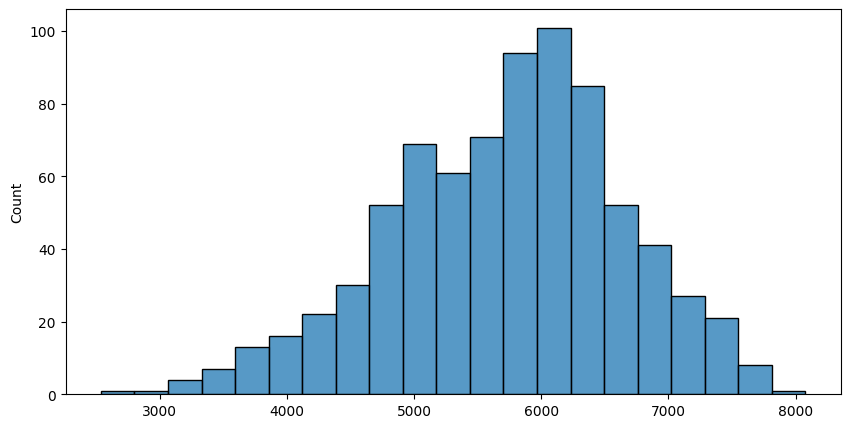

In [105]:
stats_instructions(
    instructions=instructions,
    prompt_template=prompt_template
)

In [163]:
gen_data_save_root = os.path.join(data_root, 'gen_data')
if not os.path.exists(gen_data_save_root): os.makedirs(gen_data_save_root)

# save prompt template
template_save_path = os.path.join(gen_data_save_root, 'alpaca_template.json')
with open(template_save_path, 'w', encoding='utf-8') as f:
    json.dump({'prompt_with_input_zh': alpaca_template_zh}, f, ensure_ascii=False, indent=4)

# save the qa pairs from the qa chain as the seed instructions
seed_instructions_save_path = os.path.join(gen_data_save_root, 'seed_instructions_zh.json')
with open(seed_instructions_save_path, 'w', encoding='utf-8') as f:
    json.dump(gen_instructions_zh, f, ensure_ascii=False, indent=4)

#### step6. save the instructions and the prompt template

In [127]:
from src.utils import save_instructions

In [128]:
gen_root = "../data/gen/"

In [130]:
instr_save_dir = os.path.join(gen_root, os.path.basename(data_dir.strip('/')))

save_instructions(
    instructions=instructions,
    prompt_template=prompt_template,
    save_dir=instr_save_dir
)


========================= Saved the instructions and prompt template to ../data/gen/cnki_papers_zh_mini =========================

